---
# Audio preprocessing:

Имеем записи глюкофона в формате mp3.
Сначала переведём их в wav
Затем дискретизуем (sampling_rate = 48000 Hz)
И проведём частотный анализ

In [1]:
from os import path
from pydub import AudioSegment

# files
src = "glucophone/am1_70_c_tankdrum_09.mp3" # - мелодия на глюкофоне
dst = "test.wav"

# convert wav to mp3
sound = AudioSegment.from_mp3(src)
sound.export(dst, format = "wav")
sound

Text(0.5, 1.0, 'Сигнал в частотной области')

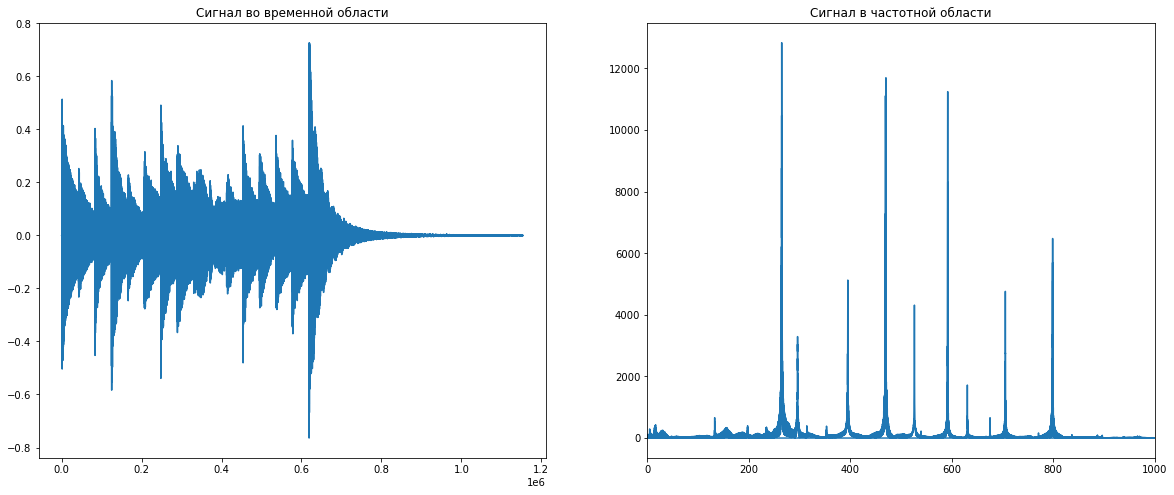

In [2]:
import numpy as np
import librosa as li
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

sample_rate = 48000
sig, sr = li.load(dst, sr = sample_rate)

plt.subplots(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(sig)
plt.title("Сигнал во временной области")

plt.subplot(1, 2, 2)
yf = fft(sig)
xf = fftfreq(len(sig), 1 / sr)
plt.plot(xf, np.abs(yf))
plt.xlim([0, 1000])
plt.title("Сигнал в частотной области")

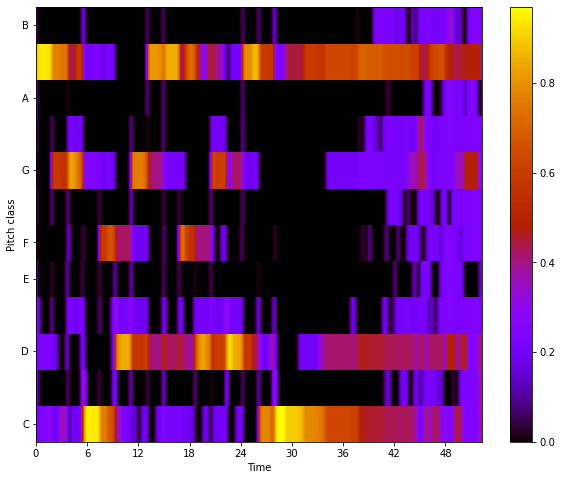

In [3]:
#Chroma Energy Normalized (CENS)
from librosa import display

#y_harmonic, y_percussive = li.effects.hpss(sig)
chroma = li.feature.chroma_cens(y = sig, sr = sr)

plt.figure(figsize = (10, 8))
display.specshow(chroma, y_axis = 'chroma', x_axis = 'time', cmap = "gnuplot")
plt.colorbar()

---

# Один тон на глюкофоне:

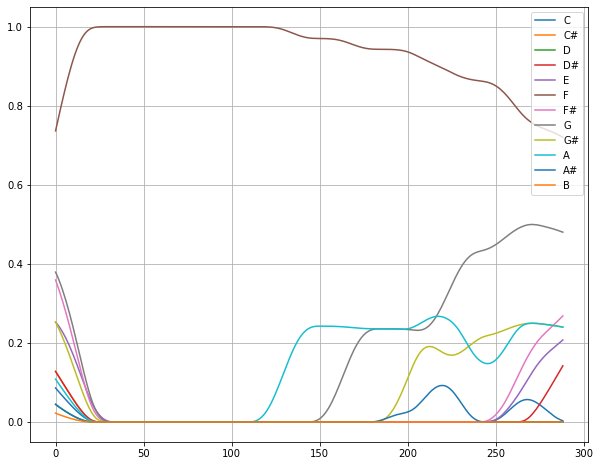

In [4]:
sound = AudioSegment.from_mp3("glucophone/344334_2007100-lq.mp3")
sound.export(dst, format = "wav")

sample_rate = 48000
sig, sr = li.load(dst, sr = sample_rate)

chroma = li.feature.chroma_cens(y = sig, sr = sr)
pitch_name = ["C","C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

plt.figure(figsize= (10, 8))
#plt.subplots(figsize = (10, 20))

for pitch_id, tmps in enumerate(chroma):
    #plt.subplot(len(chroma) // 2 + 1, 2, pitch_id + 1),
    plt.plot(tmps, label = pitch_name[pitch_id])
    plt.legend(loc = "upper right")
    plt.grid()

plt.grid()
sound

---

# Idea:

- обработать все однотоновые щаписи глюкофона в отдельную папку preprocessed_pitch
- оценить частоту тона каждой записи
- выбрать только те, которые имеют один тон

In [63]:
import glob

pitch_path_list = glob.glob("glucophone/*.mp3")[:-3]
for pitch_path in pitch_path_list:
    sound = AudioSegment.from_mp3(pitch_path)
    sound.export("glucophone/processed_pitches/" + pitch_path.split("\\")[1].split(".")[0].split('_')[0][-2:] + ".wav",
                 format = "wav")

In [67]:
import warnings
warnings.filterwarnings("ignore")

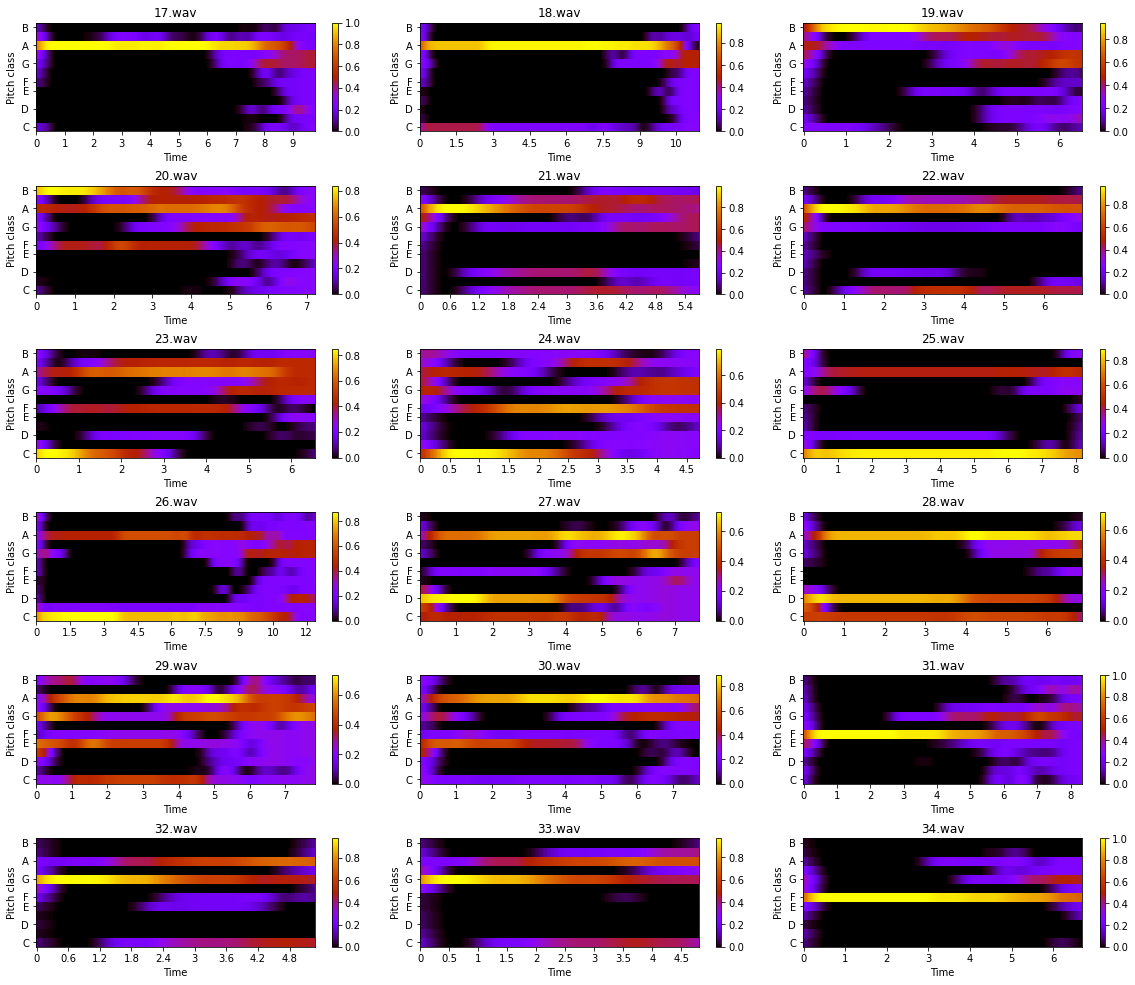

In [68]:
sr = 48000
path_list = glob.glob("glucophone/processed_pitches/*")

fig = plt.subplots(figsize = (20, 20))
plt.subplots_adjust(wspace = 0.1, hspace = 0.5)

sig_dict = {}
for i, pitch in enumerate(path_list):

    sig, _ = li.load(pitch, sr = sr)
    chroma = li.feature.chroma_cens(y = sig, sr = sr)

    plt.subplot(len(path_list)//3 + 1, 3, i + 1)

    display.specshow(chroma, y_axis = 'chroma', x_axis = 'time', cmap = "gnuplot")
    plt.colorbar()

    sig_num = pitch.split("/")[1].split("\\")[1].split(".")[0]
    sig_dict[sig_num] = sig

    plt.title(sig_num + ".wav")

---
# Multinomial decomposition - Applying FFT:

In [96]:
import torch
from pathlib import Path
import librosa as li
from os import makedirs, path
from tqdm import tqdm
import numpy as np
from scipy.io.wavfile import read as read_wav_file


def dummy_load(name, sr = 48000):
    """
    Preprocess function that takes one audio path and load it into
    chunks of 2048 samples.
    """
    x = li.load(name, sr = sr)[0]
    if len(x) % 2048:
        x = x[:-(len(x) % 2048)]
    x = x.reshape(-1, 2048)
    if x.shape[0]:
        return x
    else:
        return None


def simple_audio_preprocess(sampling_rate, N):
    def preprocess(name):
        try:
            x, sr = li.load(name, sr=sampling_rate)
        except KeyboardInterrupt:
            exit()
        except Exception as e:
            print(e)
            return None


        pad = (N - (len(x) % N)) % N
        x = np.pad(x, (0, pad))

        x = x.reshape(-1, N)
        return x.astype(np.float32)

    return preprocess


class SimpleDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            out_database_location,
            folder_list=None,
            file_list=None,
            preprocess_function=dummy_load,
            transforms=None,
            extension="*.wav,*.aif",
            map_size=1e11,
            split_percent=.2,
            split_set="train",
            seed=0,
    ):
        super().__init__()

        assert folder_list is not None or file_list is not None
        makedirs(out_database_location, exist_ok=True)

        self.env = SimpleLMDBDataset(out_database_location, map_size)

        self.folder_list = folder_list
        self.file_list = file_list

        self.preprocess_function = preprocess_function
        self.extension = extension

        self.transforms = transforms

        # IF NO DATA INSIDE DATASET: PREPROCESS
        self.len = len(self.env)

        if self.len == 0:
            self._preprocess()
            self.len = len(self.env)

        if self.len == 0:
            raise Exception("No data found !")

        self.index = np.arange(self.len)
        np.random.seed(seed)
        np.random.shuffle(self.index)

        if split_set == "train":
            self.len = int(np.floor((1 - split_percent) * self.len))
            self.offset = 0

        elif split_set == "test":
            self.offset = int(np.floor((1 - split_percent) * self.len))
            self.len = self.len - self.offset

        elif split_set == "full":
            self.offset = 0

    def _preprocess(self):
        extension = self.extension.split(",")
        idx = 0
        wavs = []

        # POPULATE WAV LIST
        if self.folder_list is not None:
            for f, folder in enumerate(self.folder_list.split(",")):
                print("Recursive search in {}".format(folder))
                for ext in extension:
                    wavs.extend(list(Path(folder).rglob(ext)))

        else:
            with open(self.file_list, "r") as file_list:
                wavs = file_list.read().split("\n")

        loader = tqdm(wavs)
        for wav in loader:
            loader.set_description("{}".format(path.basename(wav)))
            output = self.preprocess_function(wav)
            if output is not None:
                for o in output:
                    self.env[idx] = o
                    idx += 1

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        data = self.env[self.index[index + self.offset]]
        if self.transforms is not None:
            data = self.transforms(data)
        return data

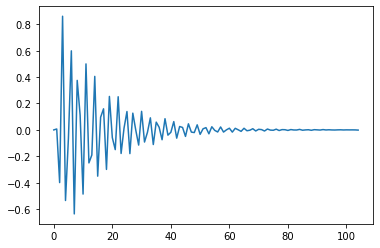

In [99]:
import pandas as pd
df = pd.DataFrame(dummy_load(path_list[0]))
plt.plot(df[0])

In [ ]:
def multiscale_stft(signal, scales, overlap):
    """
    Compute a stft on several scales, with a constant overlap value.
    Parameters
    ----------
    signal: torch.Tensor
        input signal to process ( B X C X T )

    scales: list
        scales to use
    overlap: float
        overlap between windows ( 0 - 1 )
    """
    signal = rearrange(signal, "b c t -> (b c) t")
    stfts = []
    for s in scales:
        S = torch.stft(
            signal,
            s,
            int(s * (1 - overlap)),
            s,
            torch.hann_window(s).to(signal),
            True,
            normalized=True,
            return_complex=True,
        ).abs()
        stfts.append(S)
    return stfts
